# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from xgboost import *

In [2]:
from helper import *

# Models

In [3]:
def short_term(model,x_train,y_train,x_test,y_test,x_val=False,y_val=False):
    if model=='rft':
        # perform randomized search cross validation
        rf = RandomForestRegressor(random_state=42, min_samples_split = 10)
#         rf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, random_state=42, n_jobs = -1)
        rf.fit(x_train, y_train)
        # the optimal parameters
#         rf_random.best_estimator_.get_params()
        # evaluate the optimal model
#         model_ = rf.best_estimator_
        model_ = rf
        
    elif model=='xgbc':
        xgbc=XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=2)
        xgbc.fit(x_train, y_train)
        model_=xgbc
    
    ypred = model_.predict(x_test)
    
    return ypred

In [4]:
df = read_our_data('DK_2_filled.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         43776 non-null  datetime64[ns]
 1   Date              43776 non-null  datetime64[ns]
 2   TTF               43776 non-null  float64       
 3   CO2               43776 non-null  float64       
 4   Day-ahead prices  43776 non-null  float64       
 5   Forecasted Load   43774 non-null  float64       
 6   Actual Load       43774 non-null  float64       
 7   Solar             43344 non-null  float64       
 8   Wind Offshore     43680 non-null  float64       
 9   Wind Onshore      43632 non-null  float64       
 10  Wind Total        43632 non-null  float64       
 11  Year              43776 non-null  int64         
 12  Quarter           43776 non-null  int64         
 13  Month             43776 non-null  int64         
 14  Day               4377

In [6]:
# lagged columns to add
lags = [24, 25, 26, 27, 28, 48, 72]
col_to_lag = 'Day-ahead prices'
df_lagged = lag_df(df, col_to_lag, lags)
df_lagged.dropna(how = 'any', axis = 'index', inplace = True)

In [7]:
df_lagged.columns

Index(['Timestamp', 'Date', 'TTF', 'CO2', 'Day-ahead prices',
       'Forecasted Load', 'Actual Load', 'Solar', 'Wind Offshore',
       'Wind Onshore', 'Wind Total', 'Year', 'Quarter', 'Month', 'Day', 'Hour',
       'Week', 'business', 'Day-ahead prices-lag24', 'Day-ahead prices-lag25',
       'Day-ahead prices-lag26', 'Day-ahead prices-lag27',
       'Day-ahead prices-lag28', 'Day-ahead prices-lag48',
       'Day-ahead prices-lag72'],
      dtype='object')

In [25]:
cols_std = ['TTF', 'CO2', 'Forecasted Load', 'Actual Load',
            'Solar', 'Wind Offshore', 'Wind Onshore', 'Wind Total',
             'Day', 'Hour', 'Week', 'Day-ahead prices-lag24', 'Day-ahead prices-lag25', 'Day-ahead prices-lag26',
            'Day-ahead prices-lag27', 'Day-ahead prices-lag28', 'Day-ahead prices-lag48', 'Day-ahead prices-lag72']
features = cols_std + ['Quarter', 'Month', 'business']
target = ['Day-ahead prices']
train_start = pd.to_datetime(['2018-01-01', '2021-01-01', '2021-07-01'], format = '%Y-%m-%d')

In [27]:
k_folds = 3
for k in range(k_folds):
    # split in train and test set
    train_set, test_set = split_timeseries(df_lagged, train_start, k, method = 0)
    
    # get features and target
    X_train, y_train = get_feature_target(train_set, features, target)
    X_test, y_test = get_feature_target(test_set, features, target)
    y_test = np.array(y_test[target])

    # standardize
    X_train_std, X_test_std = standardize(X_train, X_test, cols_std)
 
    # short  term
    ypred = short_term('rft', X_train_std, y_train, X_test_std, y_test)

In [31]:
train_set

,Timestamp,Date,TTF,CO2,Day-ahead prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,...,Hour,Week,business,Day-ahead prices-lag24,Day-ahead prices-lag25,Day-ahead prices-lag26,Day-ahead prices-lag27,Day-ahead prices-lag28,Day-ahead prices-lag48,Day-ahead prices-lag72
0,2021-07-01 00:00:00,2021-07-01,36.145,58.06,75.90,3131.0,3185.0,0.0,556.0,835.0,...,0,26,True,79.02,80.82,84.59,94.97,96.33,76.33,73.38
1,2021-07-01 01:00:00,2021-07-01,36.145,58.06,73.73,3091.0,3113.0,0.0,612.0,934.0,...,1,26,True,75.63,79.02,80.82,84.59,94.97,74.98,70.20
2,2021-07-01 02:00:00,2021-07-01,36.145,58.06,72.01,3080.0,3098.0,0.0,641.0,1017.0,...,2,26,True,74.13,75.63,79.02,80.82,84.59,73.45,68.92
3,2021-07-01 03:00:00,2021-07-01,36.145,58.06,71.24,3092.0,3109.0,2.0,691.0,1117.0,...,3,26,True,74.03,74.13,75.63,79.02,80.82,74.52,69.15
4,2021-07-01 04:00:00,2021-07-01,36.145,58.06,73.96,3249.0,3222.0,29.0,760.0,1144.0,...,4,26,True,78.03,74.03,74.13,75.63,79.02,78.46,74.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10892,2022-10-08 20:00:00,2022-10-08,156.205,69.85,41.98,3294.0,3337.0,0.0,1155.0,1590.0,...,20,40,False,49.94,38.96,49.95,51.97,33.91,41.01,17.00
10893,2022-10-08 21:00:00,2022-10-08,156.205,69.85,41.95,3136.0,3167.0,0.0,1037.0,1429.0,...,21,40,False,51.19,49.94,38.96,49.95,51.97,36.19,20.23
10894,2022-10-08 22:00:00,2022-10-08,156.205,69.85,44.12,2961.0,3027.0,0.0,923.0,1208.0,...,22,40,False,49.91,51.19,49.94,38.96,49.95,25.88,1.89
10895,2022-10-08 23:00:00,2022-10-08,156.205,69.85,97.50,2827.0,2832.0,0.0,775.0,882.0,...,23,40,False,44.68,49.91,51.19,49.94,38.96,16.99,0.93


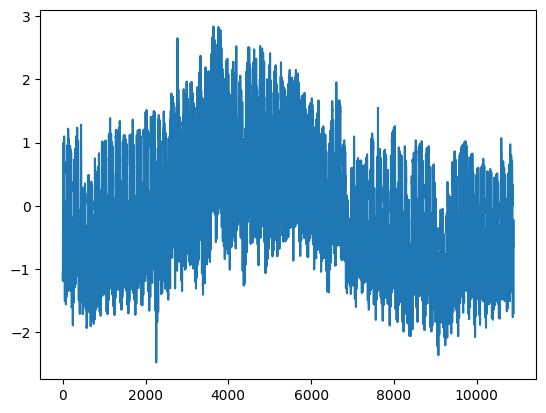

In [28]:
plt.plot((X_train['Actual Load'] - X_train['Actual Load'].mean(axis = 0))/X_train['Actual Load'].std(axis = 0))

In [29]:
X_train_std

,TTF,CO2,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,Wind Total,Day,Hour,...,Day-ahead prices-lag24,Day-ahead prices-lag25,Day-ahead prices-lag26,Day-ahead prices-lag27,Day-ahead prices-lag28,Day-ahead prices-lag48,Day-ahead prices-lag72,Quarter,Month,business
0,-1.301161,-1.320903,-1.141037,-1.072569,-0.649360,-0.237118,-0.354727,-0.326232,-1.650923,-1.660962,...,-0.711567,-0.698365,-0.670456,-0.593188,-0.583118,-0.736072,-0.764048,3,7,True
1,-1.301161,-1.320903,-1.195224,-1.170488,-0.649360,-0.105376,-0.245670,-0.206637,-1.650923,-1.516517,...,-0.736827,-0.711778,-0.698551,-0.670528,-0.593251,-0.746208,-0.787916,3,7,True
2,-1.301161,-1.320903,-1.210125,-1.190887,-0.649360,-0.037152,-0.154239,-0.120219,-1.650923,-1.372073,...,-0.748003,-0.737039,-0.711965,-0.698618,-0.670586,-0.757696,-0.797524,3,7,True
3,-1.301161,-1.320903,-1.193869,-1.175927,-0.643325,0.080476,-0.044081,-0.004482,-1.650923,-1.227628,...,-0.748748,-0.748216,-0.737228,-0.712030,-0.698675,-0.749662,-0.795798,3,7,True
4,-1.301161,-1.320903,-0.981187,-1.022250,-0.561851,0.242802,-0.014339,0.069590,-1.650923,-1.083183,...,-0.718944,-0.748961,-0.748406,-0.737289,-0.712085,-0.720080,-0.759394,3,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10892,0.853525,-0.367222,-0.920227,-0.865853,-0.649360,1.172059,0.476966,0.718493,-0.858218,1.227933,...,-0.928248,-1.010287,-0.928600,-0.913577,-1.048176,-1.001261,-1.187227,4,10,False
10893,0.853525,-0.367222,-1.134264,-1.097049,-0.649360,0.894458,0.299611,0.503221,-0.858218,1.372377,...,-0.918934,-0.928469,-1.010500,-0.928628,-0.913620,-1.037450,-1.162983,4,10,False
10894,0.853525,-0.367222,-1.371330,-1.287446,-0.649360,0.626268,0.056162,0.244740,-0.858218,1.516822,...,-0.928471,-0.919155,-0.928675,-1.010514,-0.928670,-1.114859,-1.300641,4,10,False
10895,0.853525,-0.367222,-1.552855,-1.552641,-0.649360,0.278090,-0.302952,-0.120991,-0.858218,1.661267,...,-0.967441,-0.928693,-0.919360,-0.928703,-1.010551,-1.181607,-1.307846,4,10,False


In [33]:
y_test.shape

(1874, 1)

In [34]:
ypred.shape

(1874,)

In [35]:
model_evaluation(y_test, ypred)

Mean Absolute Error (MAE): 48.49318527315472
Mean Squared Error (MSE): 4190.129930798026
Root Mean Squared Error (RMSE): 64.73121295633217
Mean Absolute Percentage Error (MAPE): 1408.23
Accuracy: -1308.23
